# Methylation - Expression _in cis_

In [1]:
source(here::here("scripts/init.R"))

### Remove TME genes

We start by identifying genes that are strongly correlated to TME (immune and CAF) in the expression-methylation correlation clusters. Our TME normalization cleaned most of their correlations with methylation, but it is not perfect we don't want their _in cis_ effects to mask other more interesting expression-methylation correlations. 

In [2]:
TME_genes <- {
    ER_pos_TME_genes <- get_TME_genes(readr::read_rds(here("data/ER_positive_norm_meth.rds"))$em_cross_clust)
    ER_neg_TME_genes <- get_TME_genes(readr::read_rds(here("data/ER_negative_norm_meth.rds"))$em_cross_clust)
    normal_TME_genes <- get_TME_genes(readr::read_rds(here("data/normal_norm_meth.rds"))$em_cross_clust)

    unique(c(ER_pos_TME_genes, ER_neg_TME_genes, normal_TME_genes)) 
} %cache_rds% here("data/TME_genes.rds")

length(TME_genes)

[1] 2194

In [3]:
expr_mat <- get_gene_expression_mat() %>% expr_intervs_to_mat()

In [4]:
expr_mat_f <- expr_mat[!(rownames(expr_mat) %in% TME_genes), ]

### Load normalized methylation and separate it to promoters and non-promoters

In [5]:
all_norm_meth <- fread(here("data/all_norm_meth.tsv")) %>% as_tibble() 

In [6]:
prom_meth <- all_norm_meth %>% inner_join(promoter_intervs %>% distinct(chrom, start, end), by = c("chrom", "start", "end"))

In [7]:
non_prom_meth <- all_norm_meth %>% anti_join(promoter_intervs %>% distinct(chrom, start, end), by = c("chrom", "start", "end"))

In [8]:
prom_intervs_f <- resolve_alt_promoters(prom_meth %>% select(chrom:end))

## Cis candidates: promoters

We use `methylayer` to identify promoters that are correlated _in cis_ to the expression of their gene: 

In [9]:
ER_positive_prom_mat <- prom_meth %>% select(chrom:end, any_of(ER_positive_samples)) %>% intervs_to_mat()
ER_negative_prom_mat <- prom_meth %>% select(chrom:end, any_of(ER_negative_samples)) %>% intervs_to_mat()
normal_prom_mat <- prom_meth %>% select(chrom:end, any_of(normal_samples)) %>% intervs_to_mat()


dim(ER_positive_prom_mat)
dim(ER_negative_prom_mat)
dim(normal_prom_mat)

[1] 15693  1108

[1] 15693   310

[1] 15693    92

In [10]:
prom_cis_cands <- bind_rows(
    cis_em_promoters(ER_positive_prom_mat, expr_mat_f, prom_intervs_f, min_samples=50) %>% mutate(ER = "ER+"), 
    cis_em_promoters(ER_negative_prom_mat, expr_mat_f, prom_intervs_f, min_samples=50) %>% mutate(ER = "ER-"),
    cis_em_promoters(normal_prom_mat, expr_mat_f, prom_intervs_f, min_samples=50) %>% mutate(ER = "normal") ) %cache_df% here("data/promoter_cis_cands.tsv") %>% as_tibble()  

# of samples: 1108

# of genes: 9360

calculating expression-methylation correlation...

ranking...

calculaing FDR...

# of samples: 310

# of genes: 9360

calculating expression-methylation correlation...

ranking...

calculaing FDR...

# of samples: 92

# of genes: 9360

calculating expression-methylation correlation...

ranking...

calculaing FDR...



In [11]:
max(prom_cis_cands$r)

[1] 9360

In [12]:
df <- prom_cis_cands %>% filter(r == 1)  %>% distinct(fdr, n_fdr, ER)

df_fdr <- prom_cis_cands %>% 
    filter(fdr < 0.05) %>% 
    group_by(ER) %>% 
    filter(fdr == max(fdr)) %>% 
    distinct(fdr, n_fdr, ER)

df
df_fdr

glue("we identified {n_top_ER_pos} promoters in ER+ and {n_top_ER_neg} in ER- (FDR<0.01; {n_fdr_ER_pos} in ER+ and {n_fdr_ER_neg} in ER- if increasing FDR to <0.05)", 
     n_top_ER_pos = df$n_fdr[df$ER == "ER+"], 
     n_top_ER_neg = df$n_fdr[df$ER == "ER-"], 
     n_fdr_ER_pos = df_fdr$n_fdr[df_fdr$ER == "ER+"], 
     n_fdr_ER_neg = df_fdr$n_fdr[df_fdr$ER == "ER-"])

fdr,n_fdr,ER
<dbl>,<int>,<chr>
0.002364066,423,ER+
0.005405405,185,ER-
0.250000000,4,normal


fdr,n_fdr,ER
<dbl>,<int>,<chr>
0.04938272,1053,ER+
0.04910714,448,ER-


we identified 423 promoters in ER+ and 185 in ER- (FDR<0.01; 1053 in ER+ and 448 in ER- if increasing FDR to <0.05)

### Plot correlation of top cis-regulated promoter candidates

#### Figure 3A

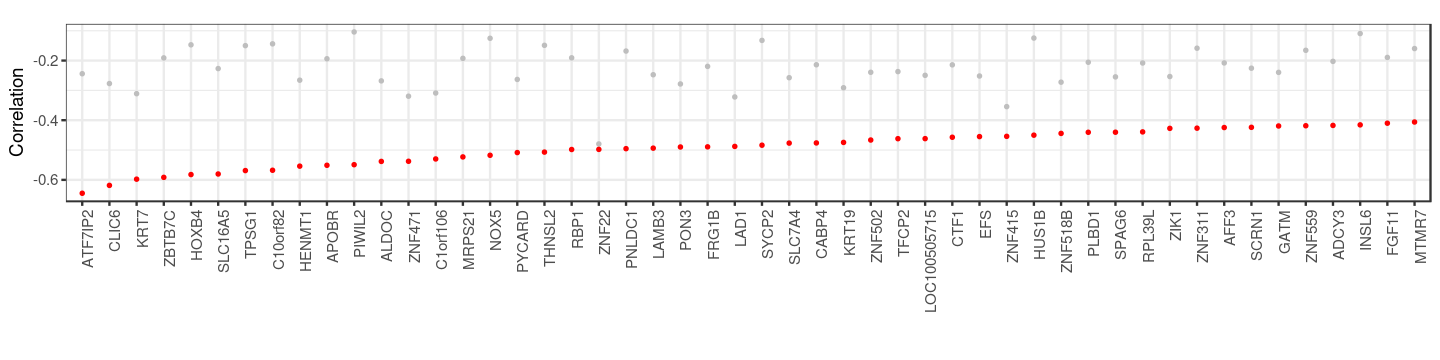

In [13]:
options(repr.plot.width = 12, repr.plot.height = 3)

p_top_cands <- prom_cis_cands %>%
        filter(r == 1) %>% 
        mutate(diff = abs(best - kth)) %>% 
        filter(ER == "ER+") %>%
        arrange(cor) %>% 
        slice(1:50) %>%
        ggplot(aes(x = reorder(name, cor), y = kth)) +
        geom_point(size = 0.5, color = "gray") +
        xlab("") +
        ylab("Correlation") +
        geom_point(aes(y = cor), color = "red", size = 0.5) +
        theme(axis.text.x = element_text(size = 5, angle = 90, hjust = 1))

p_top_cands + theme_bw() + vertical_labs() +  theme(aspect.ratio = 0.13)

#### Figure 3B

Warning message:
“Transformation introduced infinite values in continuous y-axis”


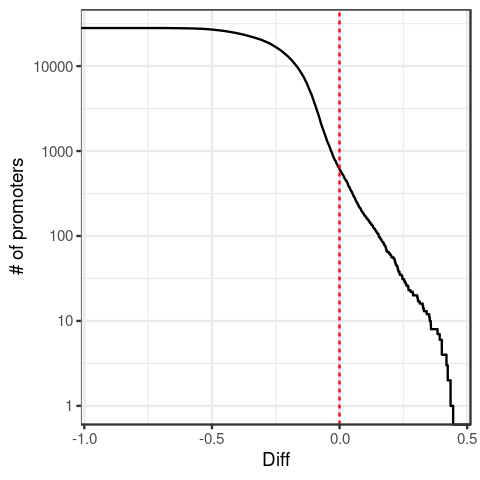

In [14]:
options(repr.plot.width = 4, repr.plot.height = 4)
p_diff <- prom_cis_cands %>%
        mutate(diff = ifelse(r == 1, kth - cor, best - cor)) %>%
        ggplot(aes(x = diff, y = (1 - ..y..) * nrow(prom_cis_cands))) +
        stat_ecdf() +
        scale_y_log10() +
        ylab("# of promoters") +
        xlab("Diff") +
        geom_vline(xintercept = 0, color = "red", linetype = "dashed") + 
        theme(aspect.ratio = 1)

p_diff + theme_bw()

### Annotation of cis-regulated promoters 

In [15]:
loci <- prom_cis_cands %>%
    group_by(chrom, start, end, name) %>%
    summarise(type = ifelse(any(r == 1), "reg", "bg"), .groups = "drop") %>%
    group_by(chrom, start, end) %>%
    summarise(type = ifelse(any(type == "reg"), "reg", "bg"), .groups = "drop")


loci_annot <- loci %>%
    select(chrom, start, end, everything()) %>%
    annotate_loci() %cache_df% here("data/promoter_cis_cands_loci.tsv") %>% as_tibble()

#### Extended Data Figure 8B

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


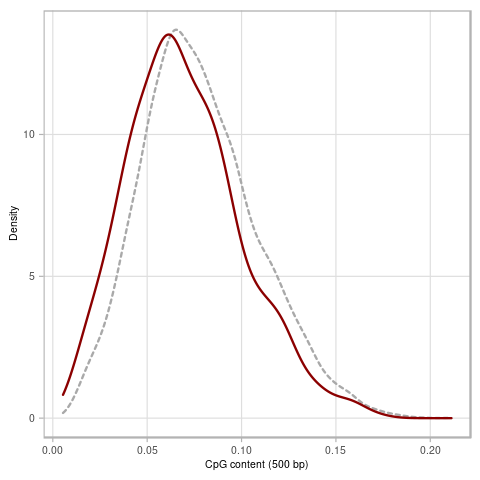

In [16]:
options(repr.plot.width = 4, repr.plot.height = 4)

p_cg_cont <- loci_annot %>%
        distinct(chrom, start, end, type, cg_cont) %>%
        ggplot(aes(x = cg_cont, color = type, linetype = type)) +
        geom_density() +
        scale_color_manual("", values = c("darkgray", "darkred"), guide = FALSE) +
        scale_linetype_manual("", values = c("dashed", "solid"), guide = FALSE) +
        xlab("CpG content (500 bp)") +
        ylab("Density") +
        theme(aspect.ratio = 1)

p_cg_cont

In [17]:
loci_annot %>% 
    filter(type == "reg") %>% 
    mutate(cg_cont = cut(cg_cont, c(0,0.04,0.08,0.2), include.lowest=TRUE)) %>% 
    count(cg_cont) %>% 
    mutate(p = scales::percent(n / sum(n)))

cg_cont,n,p
<fct>,<int>,<chr>
"[0,0.04]",79,16%
"(0.04,0.08]",254,50%
"(0.08,0.2]",170,34%


In [18]:
mean_meth <- loci %>%
        left_join(get_all_summary_meth(), by = c("chrom", "start", "end"))

#### Extended Data Figure 8A

Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


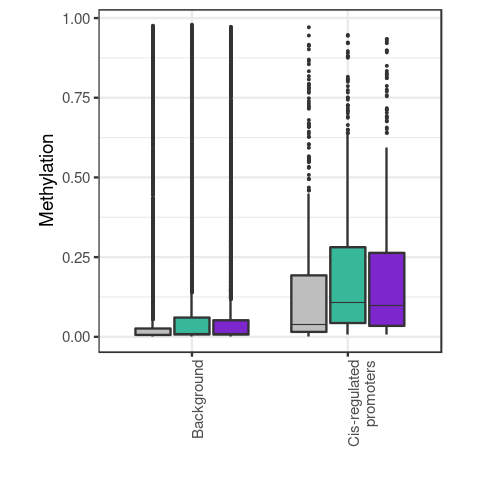

In [19]:
options(repr.plot.width = 4, repr.plot.height = 4)
df <- mean_meth %>%
        gather("ER", "meth", -(chrom:end), -type) %>% 
        mutate(ER = factor(ER, levels = c("normal", "ER+", "ER-"))) %>%
        mutate(type = forcats::fct_recode(type, "Background" = "bg", "Cis-regulated\npromoters" = "reg")) 
p_meth <- df %>% 
        ggplot(aes(x = type, y = meth, fill = ER)) +
        geom_boxplot(linewidth=0.1, fatten=0.5, outlier.size = 0.05) +         
        scale_fill_manual("", values = annot_colors$ER1, guide = FALSE) +
        xlab("") +
        ylab("Methylation") +
        theme(aspect.ratio = 1) + 
        vertical_labs()
p_meth + theme_bw() + theme(aspect.ratio = 1) + vertical_labs()

In [20]:
mean_meth %>% count(type)

type,n
<chr>,<int>
bg,8857
reg,503


In [21]:
mean_meth %>% 
    gather("ER", "meth", -(chrom:type) ) %>% 
    group_by(type, ER) %>% 
    summarise(
        m = mean(meth, na.rm=TRUE), 
        sd = sd(meth, na.rm=TRUE),
        .groups = "drop"
    )


type,ER,m,sd
<chr>,<chr>,<dbl>,<dbl>
bg,ER-,0.08122300,0.1712618
bg,ER+,0.08793721,0.1776411
bg,normal,0.06807298,0.1683802
reg,ER-,0.18820936,0.2144194
reg,ER+,0.20382981,0.2206950
reg,normal,0.15027054,0.2219690


In [22]:
mean_meth %>% 
    gather("ER", "meth", -(chrom:type) ) %>% 
    mutate(tumor_normal = ifelse(ER == "normal", "normal", "tumor")) %>% 
    group_by(type, tumor_normal) %>% 
    summarise(
        m = mean(meth, na.rm=TRUE), 
        sd = sd(meth, na.rm=TRUE),
        .groups = "drop"
    )


type,tumor_normal,m,sd
<chr>,<chr>,<dbl>,<dbl>
bg,normal,0.06807298,0.1683802
bg,tumor,0.08458010,0.1745080
reg,normal,0.15027054,0.2219690
reg,tumor,0.19601959,0.2176119


### Gene expression of cis-regulated promoters

In [23]:
mean_expr <- get_mean_expression()

In [24]:
raw_meth <- get_promoter_avg_meth()

In [25]:
top_cands <- prom_cis_cands %>%
        mutate(diff = abs(best - kth)) %>%
        filter(r == 1)

In [26]:
matched_meth <- top_cands %>%
        distinct(chrom, start, end, name) %>%
        inner_join(raw_meth) %>%
        gather("samp", "meth", -(chrom:name)) %>%
        left_join(samp_data %>% select(samp, patient, ER = ER1)) %>%
        filter(!is.na(ER)) %>%
        select(-samp) %>%
        spread(ER, meth) %>%
        filter(!is.na(normal)) %>%
        left_join(top_cands %>% select(name, ER)) %>%
        mutate(diff = ifelse(ER == "ER+", `ER+` - normal, `ER-` - normal))


Joining, by = c("chrom", "start", "end")

Joining, by = "samp"

Joining, by = "name"



In [27]:
matched_meth_df <- matched_meth %>%
        filter(!is.na(diff)) %>%
        mutate(diff_grp = cut(diff, breaks = c(-1, -0.2, 0.2, 1), include.lowest = TRUE, labels = c("hypo", "stable", "hyper"))) %>%
        unite("name", name, ER) %>%
        count(name, diff_grp) %>%
        group_by(name) %>%
        mutate(p = n / sum(n)) %>%
        tidyr::complete(diff_grp, fill = list(p = 0)) %>%
        filter(!is.na(diff_grp)) %>%
        mutate(p_hypo = p[diff_grp == "hypo"], p_hyper = p[diff_grp == "hyper"], p_stable = p[diff_grp == "stable"]) %>%
        ungroup() %>%
        arrange((p_hypo - p_hyper) / (p_stable + 1)) %>%
        mutate(name = forcats::fct_inorder(name)) 

In [28]:
cat(sprintf("# of meth genes: %s", matched_meth_df %>% distinct(name) %>% nrow() ) )

# of meth genes: 612

#### Figure 3C

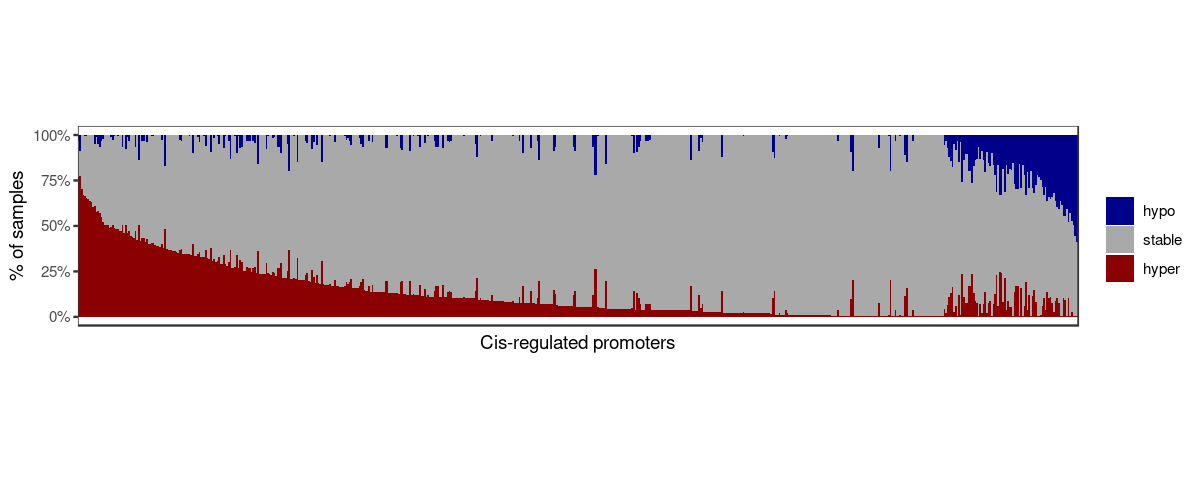

In [29]:
options(repr.plot.width = 10, repr.plot.height = 4)
p_meth_dist <- matched_meth_df %>%
        ggplot(aes(x = name, y = p, fill = diff_grp)) +
        geom_col() +
        scale_fill_manual("", values = c(hypo = "darkblue", stable = "darkgray", hyper = "darkred")) +
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank(), aspect.ratio = 0.4) +
        scale_y_continuous(labels = scales::percent) +
        ylab("% of samples") +
        xlab("Cis-regulated promoters")

p_meth_dist + theme_bw() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank(), aspect.ratio = 0.2)

In [30]:
expr_mat <- get_gene_expression_mat()

In [31]:
matched_expr <- expr_mat %>%
        filter(name %in% top_cands$name) %>%
        gather("samp", "expr", -(chrom:name3.chr)) %>%
        left_join(samp_data %>% select(samp, patient, ER = ER1)) %>%
        filter(!is.na(ER)) %>%
        select(-samp) %>%
        spread(ER, expr) %>%
        filter(!is.na(normal)) %>%
        left_join(top_cands %>% select(name, ER))

Joining, by = "samp"

Joining, by = "name"



In [32]:
matched_expr <- matched_expr %>% mutate(diff = ifelse(ER == "ER+", `ER+` - normal, `ER-` - normal))

In [33]:
matched_expr_df <- matched_expr %>%
    filter(!is.na(diff)) %>%
    mutate(diff_grp = cut(diff, breaks = c(-20, -1, 1, 20), include.lowest = TRUE, labels = c("repressed", "stable", "induced"))) %>%
    unite("name", name, ER) %>%
    count(name, diff_grp) %>%
    group_by(name) %>%
    mutate(p = n / sum(n)) %>%
    tidyr::complete(diff_grp, fill = list(p = 0)) %>%
    filter(!is.na(diff_grp)) %>%
    mutate(p_repressed = p[diff_grp == "repressed"], p_induced = p[diff_grp == "induced"], p_stable = p[diff_grp == "stable"]) %>%
    ungroup() %>%
    arrange((p_induced - p_repressed) / (p_stable + 1)) %>%
    mutate(name = forcats::fct_inorder(name))

cat(sprintf("# of expr genes: %s", matched_expr_df %>% distinct(name) %>% nrow() ) )

# of expr genes: 612

#### Figure 3D

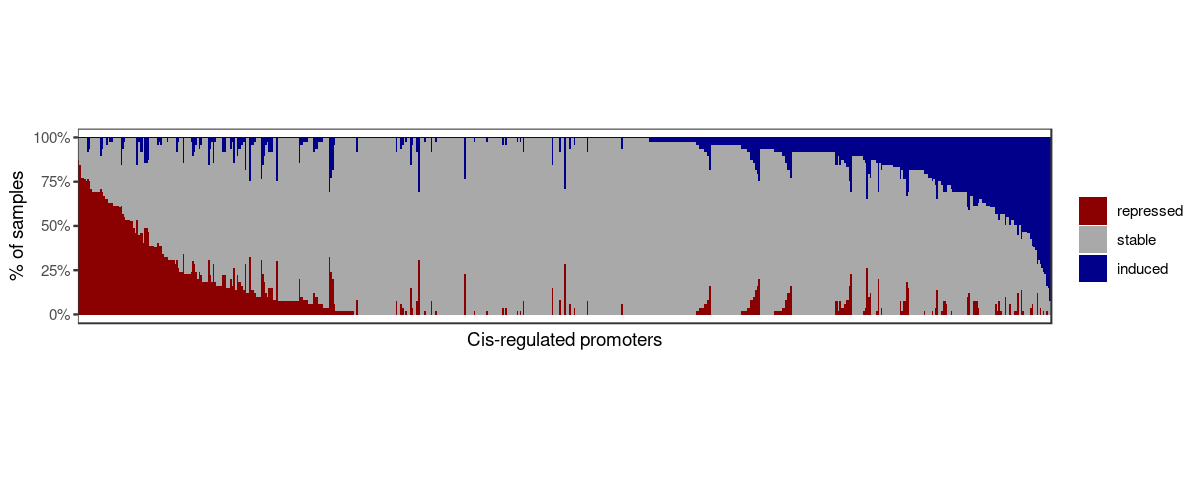

In [34]:
options(repr.plot.width = 10, repr.plot.height = 4)
p_expr_dist <- matched_expr_df %>%
        mutate(diff_grp = factor(diff_grp, levels = rev(c("repressed", "stable", "induced")))) %>% 
        ggplot(aes(x = name, y = p, fill = diff_grp)) +
        geom_col() +
        scale_fill_manual("", values = c(repressed = "darkred", stable = "darkgray", induced =  "darkblue")) +
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank(), aspect.ratio = 0.4) +
        scale_y_continuous(labels = scales::percent) +
        ylab("% of samples") +
        xlab("Cis-regulated promoters")

p_expr_dist + theme_bw() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank(), aspect.ratio = 0.2) 

### Correlation between cis-regulated genes

#### Extended Data Figure 8C

In [35]:
cands_expr <- expr_mat %>%
        filter(name %in% (top_cands %>% filter(ER == "ER+") %>% pull(name))) %>%
        select(any_of(c("name", ER_positive_samples))) %>%
        as.data.frame() %>%
        column_to_rownames("name") %>%
        as.matrix()

In [36]:
cm <- tgs_cor(t(cands_expr), pairwise.complete.obs = TRUE)
hc <- hclust(tgs_dist(cm), method = "ward.D2")

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


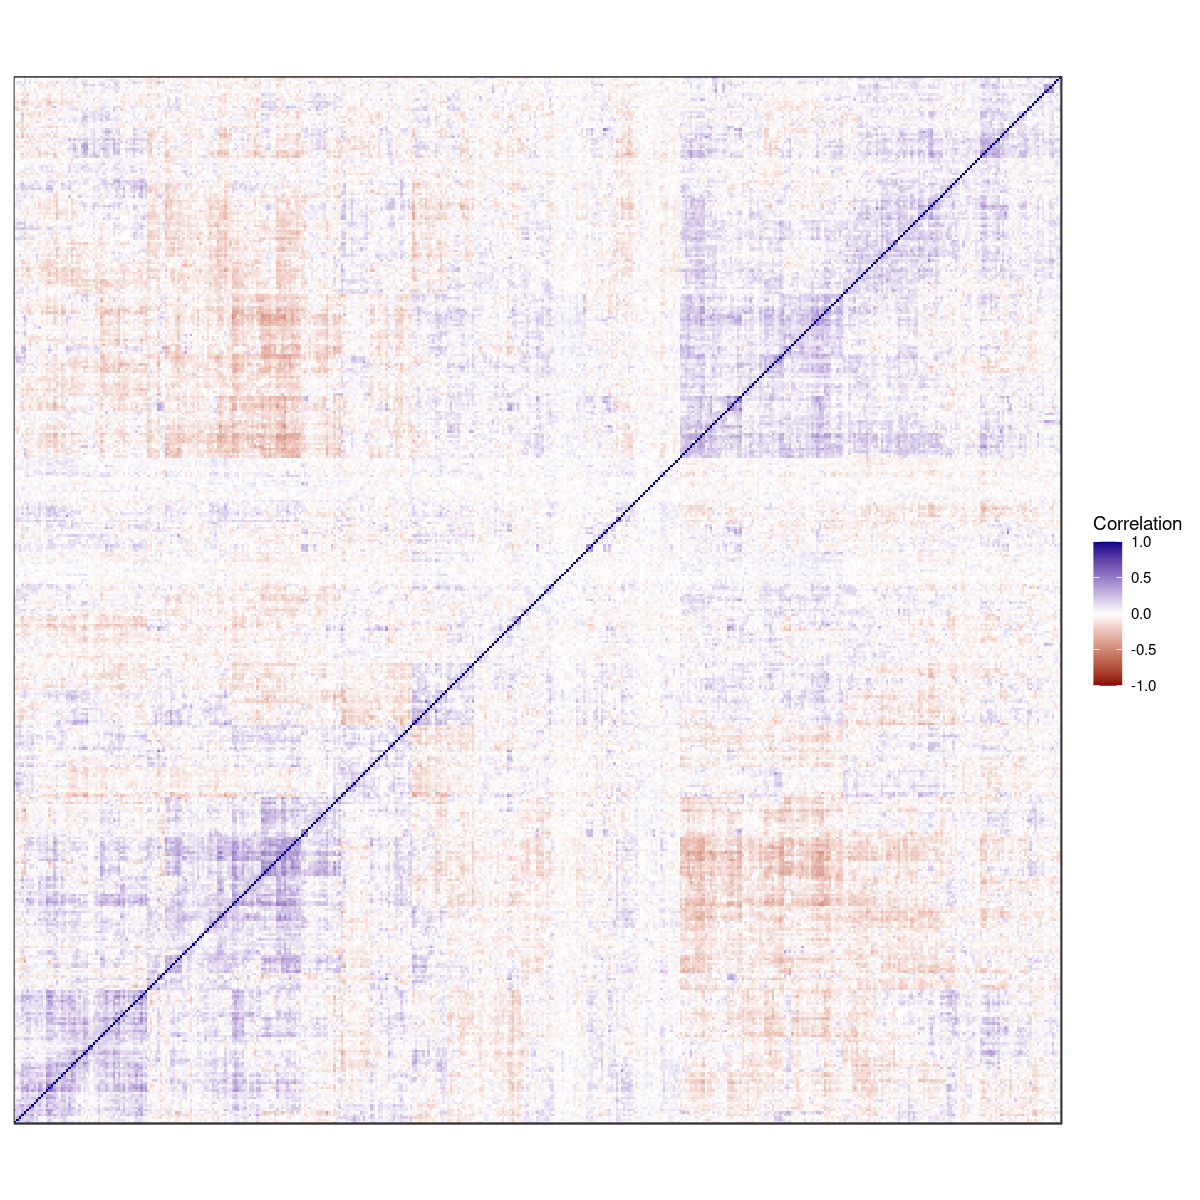

In [37]:
options(repr.plot.width = 10, repr.plot.height = 10)
p_cor <- tgutil::tgplot_heatmap(cm[hc$order, hc$order]) +
        scale_fill_gradientn("Correlation", colors = c("darkred", "white", "darkblue"), limits = c(-1, 1)) +
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), aspect.ratio = 1)
p_cor

In [38]:
dim(cm)

[1] 423 423

[1] 392

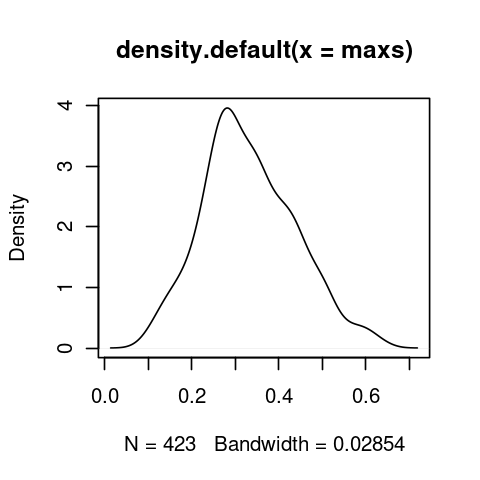

In [39]:
options(repr.plot.width = 4, repr.plot.height = 4)
cm1 <- cm
diag(cm1) <- NA
maxs <- matrixStats::rowMaxs(cm1, na.rm=TRUE) 
sum(maxs < 0.5)
plot(density(maxs))

## Epipolymorphism of cis-regulated promoters

In [40]:
prom_epipoly <- get_promoter_cis_reg_epipoly()

#### Figure 3F

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


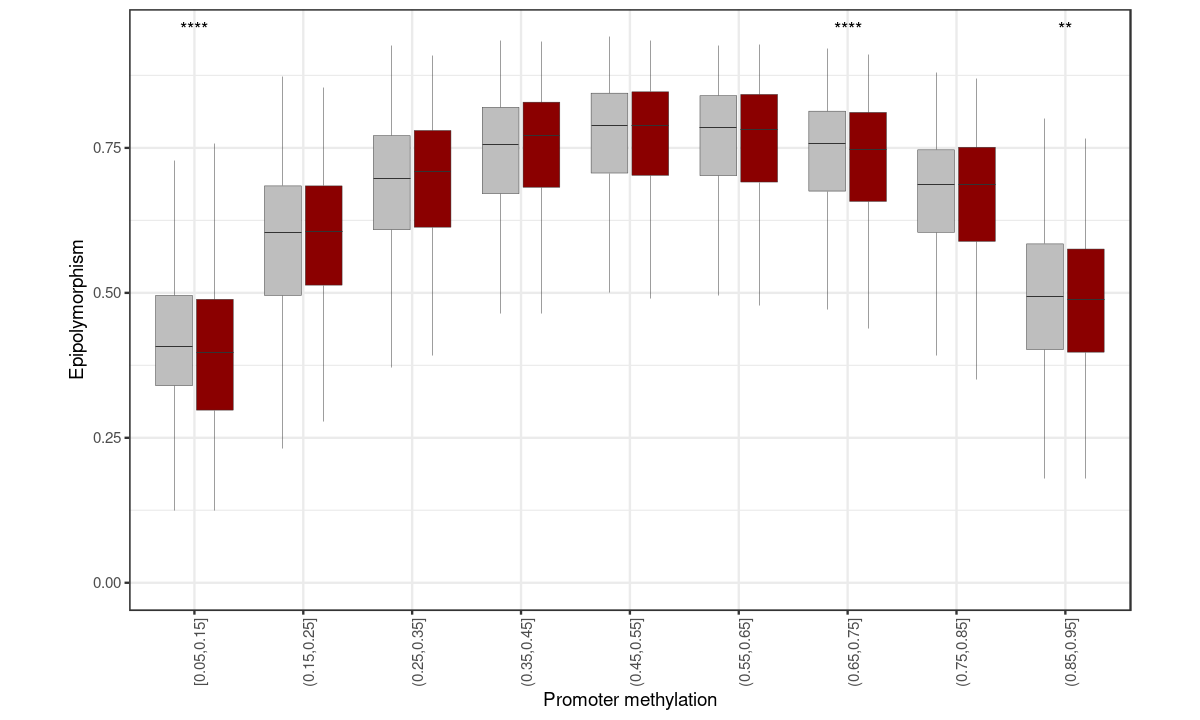

In [41]:
options(repr.plot.width = 10, repr.plot.height = 6)
p_prom_epipoly <- prom_epipoly %>%
        mutate(pat_meth = cut(pat_meth, seq(0.05, 1, 0.1), include.lowest = TRUE)) %>%
        filter(!is.na(pat_meth)) %>% 
        filter(!is.na(epipoly), !is.na(type)) %>% 
        ggplot(aes(x = pat_meth, y = epipoly, fill = type)) +
        geom_boxplot(outlier.shape = NA, outlier.size = 0.05, lwd =0.1) +
        scale_fill_manual(values = c(bg = "gray", reg = "darkred"), guide = FALSE) +
        vertical_labs() +
        xlab("Promoter methylation") +
        ylab("Epipolymorphism") +
        ggpubr::stat_compare_means(label = "p.signif", hide.ns = TRUE, method = "wilcox.test", method.args = list(alternative = "less")) +
        theme(aspect.ratio = 0.6)

p_prom_epipoly + theme_bw() + vertical_labs() + theme(aspect.ratio = 0.6)

## Promoter examples

### BRCA1

In [48]:
brca_cors <- methylayer:::gene_promoter_cors("BRCA1", ER_negative_prom_mat, expr_mat_f, prom_intervs_f)

#### Extended Data Figure 8E

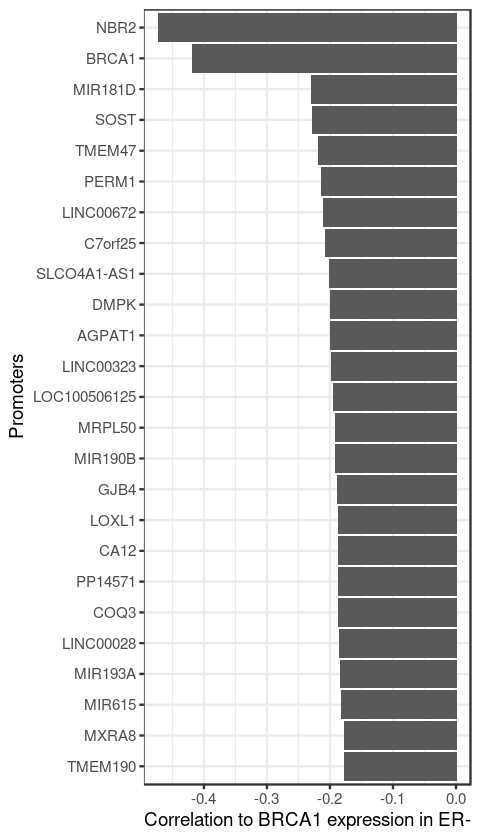

In [49]:
options(repr.plot.width = 4, repr.plot.height = 7)
p_brca_gene_cors <- brca_cors %>%     
    slice(1:25) %>% 
    ggplot(aes(x=reorder(promoter, -cor), y=cor)) + geom_col() + ylab("Correlation to BRCA1 expression in ER-") + xlab("Promoters") + coord_flip()

p_brca_gene_cors + theme_bw()

#### Figure 3E

In [53]:
genes <- c("KRT7", "CABP4", "BRCA1")
prom_cis_cands <- fread(here("data/promoter_cis_cands.tsv")) %>% as_tibble()
example_cands <- map_dfr(genes, ~ get_promoter_cand_interval(prom_cis_cands, .x, "ER+"))
cg_meth <- get_cis_promoter_examples_cg_meth(genes = genes)

Joining, by = c("name", "chrom", "start", "end")

Joining, by = "full_name"

Joining, by = c("name", "chrom", "start", "end")

Joining, by = "full_name"

Joining, by = c("name", "chrom", "start", "end")

Joining, by = "full_name"



Joining, by = c("samp", "name")

Joining, by = c("chrom", "start", "end")

Joining, by = "full_name"

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found in PostScript font dat

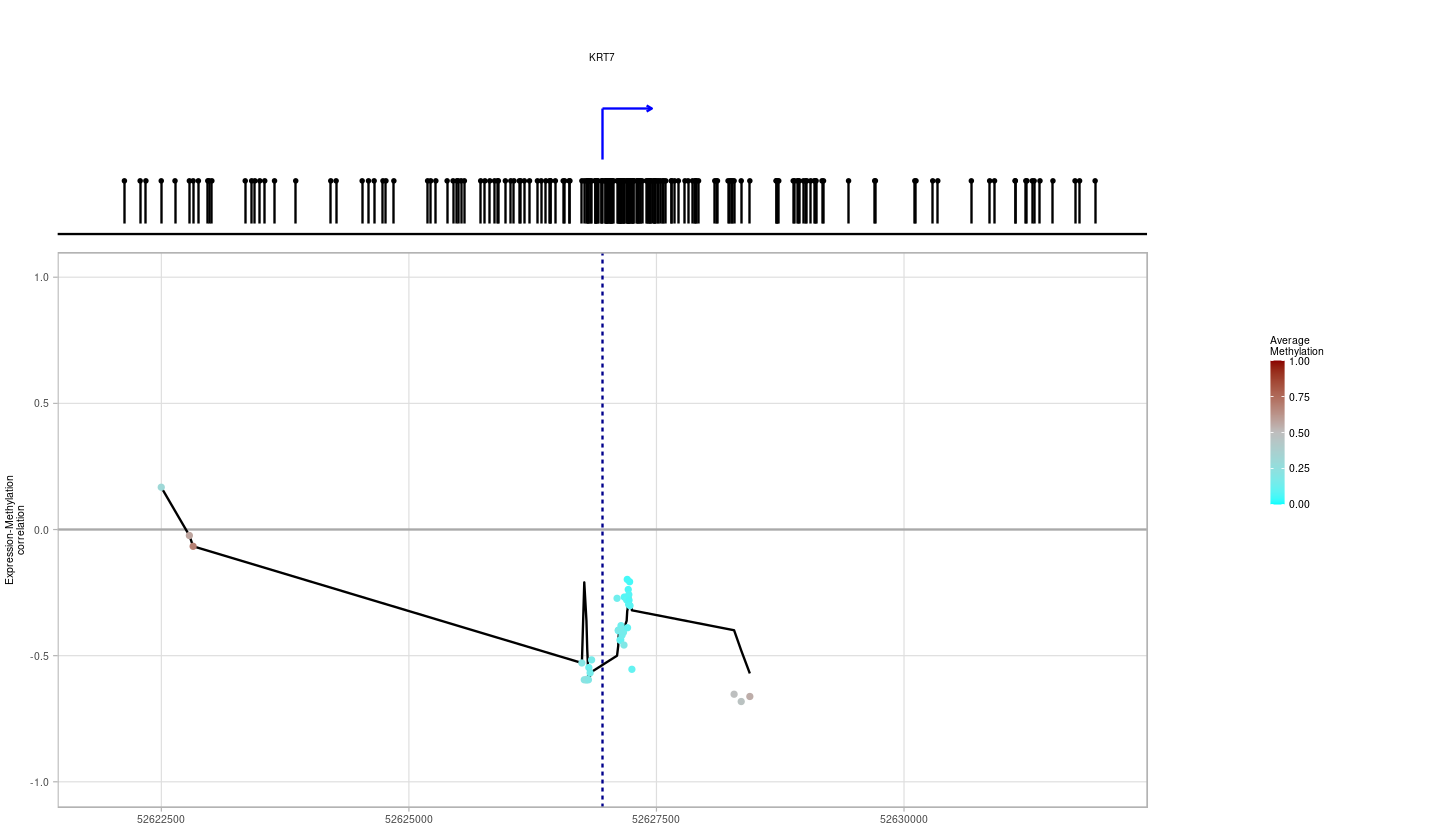

In [54]:
options(repr.plot.width = 12, repr.plot.height = 7)
krt7_p <- plot_cis_promoter_example(example_cands %>% filter(name == "KRT7"), cg_meth, "ER+", resolution = 5e3, plot_all_tss_lines = TRUE)

krt7_p

Joining, by = c("samp", "name")

Warning message in cor(expr, avg_m, use = "pairwise.complete.obs"):
“the standard deviation is zero”
Warning message in cor(expr, avg_m, use = "pairwise.complete.obs"):
“the standard deviation is zero”
Warning message in cor(expr, avg_m, use = "pairwise.complete.obs"):
“the standard deviation is zero”
Warning message in cor(expr, avg_m, use = "pairwise.complete.obs"):
“the standard deviation is zero”
Warning message in cor(expr, avg_m, use = "pairwise.complete.obs"):
“the standard deviation is zero”
Warning message in cor(expr, avg_m, use = "pairwise.complete.obs"):
“the standard deviation is zero”
Warning message in cor(expr, avg_m, use = "pairwise.complete.obs"):
“the standard deviation is zero”
Warning message in cor(expr, avg_m, use = "pairwise.complete.obs"):
“the standard deviation is zero”
Warning message in cor(expr, avg_m, use = "pairwise.complete.obs"):
“the standard deviation is zero”
Warning message in cor(expr, avg_m, use = "pairwise.comple

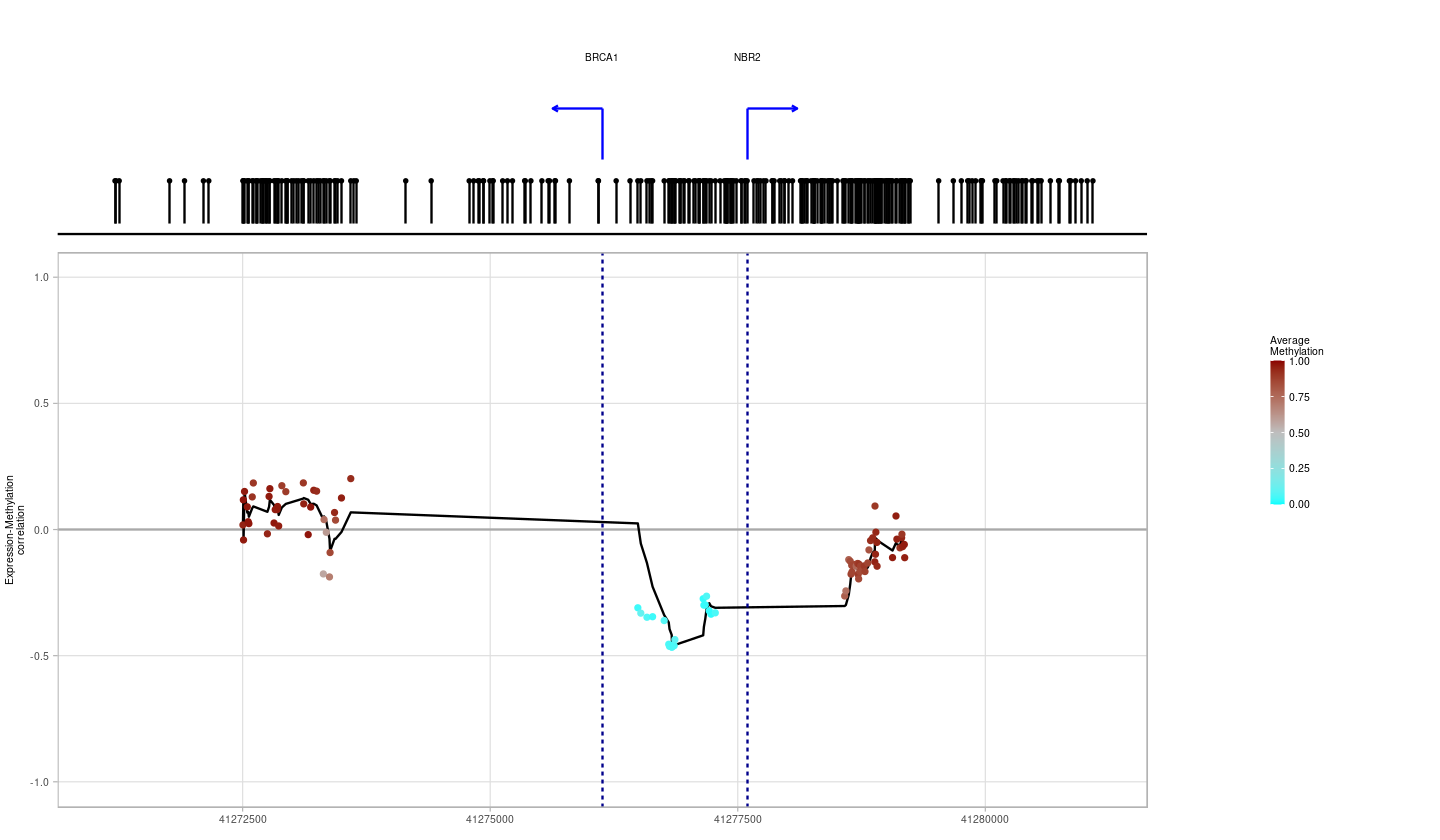

In [55]:
options(repr.plot.width = 12, repr.plot.height = 7)

brca1_p <- plot_cis_promoter_example(example_cands %>% filter(name == "BRCA1"), cg_meth, "ER-", resolution = 5e3, plot_all_tss_lines = TRUE)

brca1_p

## Cis candidates: genomic

We use `methylayer` to identify non promoter regions that are correlated _in cis_ to expression of _any_ gene within their vicinity. 

In [56]:
ER_positive_genomic_mat <- non_prom_meth %>% select(chrom:end, any_of(ER_positive_samples)) %>% intervs_to_mat()
ER_negative_genomic_mat <- non_prom_meth %>% select(chrom:end, any_of(ER_negative_samples)) %>% intervs_to_mat()
normal_genomic_mat <- non_prom_meth %>% select(chrom:end, any_of(normal_samples)) %>% intervs_to_mat()



dim(ER_positive_genomic_mat)
dim(ER_negative_genomic_mat)
dim(normal_genomic_mat)

[1] 185389   1108

[1] 185389    310

[1] 185389     92

In [57]:
gene_tss <- get_gene_tss_coord()

Joining, by = "full_name"



In [59]:
genomic_cands_ER_pos <- cis_em_genomic(ER_positive_genomic_mat, expr_mat_f, gene_tss, min_samples=50, max_dist = 5e5, min_dist = 200) %>% mutate(ER = "ER+") %cache_df% here("data/genomic_cis_cands_ER_positive.tsv")

In [60]:
genomic_cands_ER_neg <- cis_em_genomic(ER_negative_genomic_mat, expr_mat_f, gene_tss, min_samples=50, max_dist = 5e5, min_dist = 200) %>% mutate(ER = "ER-") %cache_df% here("data/genomic_cis_cands_ER_negative.tsv")

In [61]:
genomic_cands_normals <- cis_em_genomic(normal_genomic_mat, expr_mat_f, gene_tss, min_samples=50, max_dist = 5e5, min_dist = 200) %>% mutate(ER = "normal") %cache_df% here("data/genomic_cis_cands_normal.tsv")

In [62]:
genomic_cis_cands <- bind_rows(
    genomic_cands_ER_pos,
    genomic_cands_ER_neg,
    genomic_cands_normals) %>% as_tibble()
head(genomic_cis_cands)
dim(genomic_cis_cands)

chrom,start,end,type,rank,gene,cor,chrom_expr,start_expr,end_expr,strand_expr,dist,n_obs,n_shuff,fdr,ER
<chr>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>
chr1,10496,10587,obs,1,CT45A3,-0.2446525,chrX,134883487,134883488,1,NA,2680,92,0.03432836,ER+
chr1,10588,10639,obs,1,DSCR8,-0.1658337,chr21,39493544,39493545,1,NA,2680,92,0.03432836,ER+
chr1,134998,135215,obs,1,MAGEC2,-0.2381125,chrX,141293076,141293077,-1,NA,2680,92,0.03432836,ER+
chr1,546168,546310,obs,1,MAGEA8,-0.2542376,chrX,149009940,149009941,1,NA,2680,92,0.03432836,ER+
chr1,565396,565791,obs,1,RAD51C,-0.2153869,chr17,56769933,56769934,1,NA,2680,92,0.03432836,ER+
chr1,567121,567237,obs,1,TIMM23,-0.2271249,chr10,51623386,51623387,-1,NA,2680,92,0.03432836,ER+


[1] 55616700       16

In [63]:
dim(expr_mat_f)

[1] 24051  2124

### Plot % cis

#### Figure 3G

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


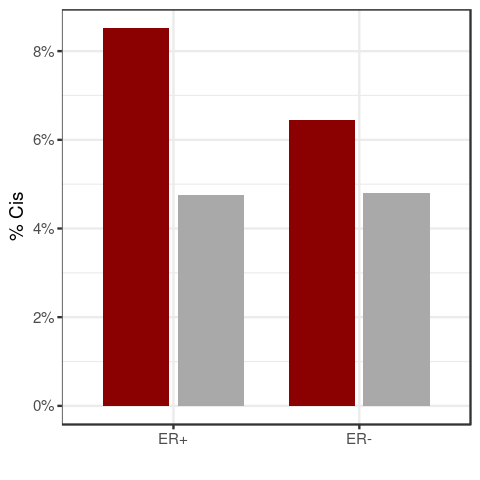

In [64]:
options(repr.plot.width = 4, repr.plot.height = 4)

p_cis <- genomic_cis_cands %>%
        filter(ER != "normal") %>% 
        mutate(ER = factor(ER, levels=c("ER+", "ER-"))) %>% 
        mutate(ER = factor(ER, levels = c("ER+", "ER-"))) %>%    
        filter(rank == 1) %>% 
        group_by(type, ER) %>%
        summarise(n = n(), n_na = sum(is.na(dist))) %>%
        mutate(p = 1 - (n_na / n)) %>%
        mutate(label = glue("{scales::comma(n_na)}/{scales::comma(n)}")) %>%
        ggplot(aes(x = ER, y = p, fill = type, label = label)) +
        geom_col(width = 0.7, position = position_dodge(width = 0.8)) +
        scale_y_continuous(label = function(x) scales::percent(x, accuracy = 1)) +
        ylab("% Cis") +
        scale_fill_manual(values = c(shuff = "darkgray", obs = "darkred"), guide = FALSE) +
        xlab("")

p_cis + theme_bw() 


### Plot distance to most correlated gene

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


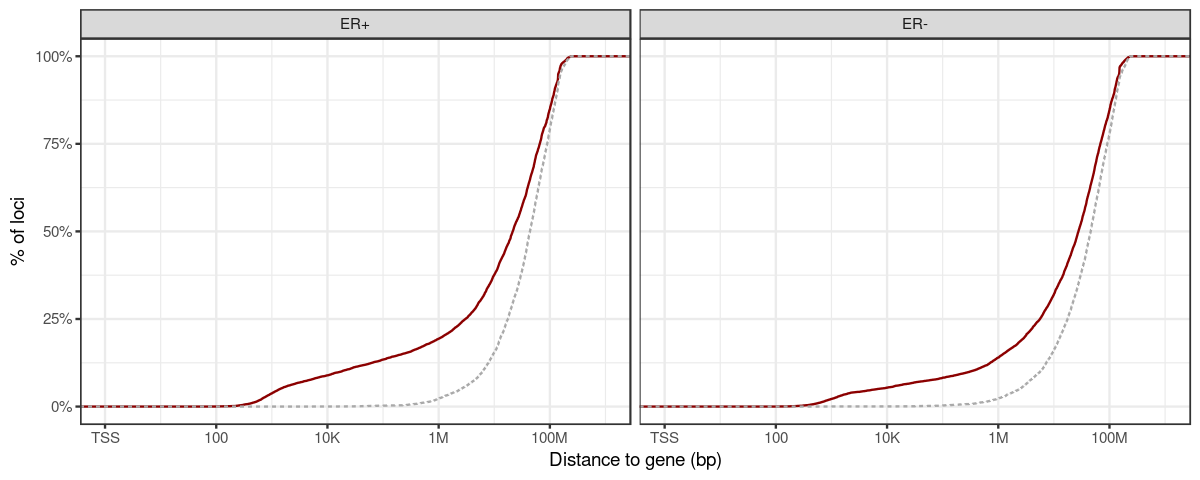

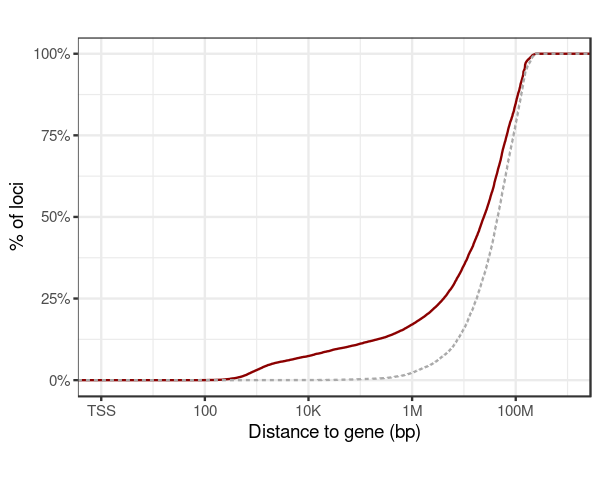

In [65]:
options(repr.plot.width = 10, repr.plot.height = 4)

p_cis_decay <- genomic_cis_cands %>%
        filter(ER != "normal") %>% 
        mutate(ER = factor(ER, levels=c("ER+", "ER-"))) %>% 
        filter(!is.na(dist), is.finite(dist)) %>% 
        filter(rank == 1) %>% 
        ggplot(aes(x = abs(dist), color = type, linetype = type)) +
        stat_ecdf() +
        scale_color_manual("", values = c(shuff = "darkgray", obs = "darkred"), guide = FALSE) +
        scale_linetype_manual("", values = c(shuff = "dashed", obs = "solid"), guide = FALSE) +
        scale_x_log10(labels = c("TSS", "100", "10K", "1M", "100M"), breaks = c(1, 100, 1e4, 1e6, 1e8), limits = c(1, 1e9)) + 
        scale_y_continuous(labels = scales::percent) +
        theme(aspect.ratio = 0.7) +
        xlab("Distance to gene (bp)") +
        ylab("% of loci") 

p_cis_decay + facet_wrap(~ER) + theme_bw() + theme(aspect.ratio = 0.7)

options(repr.plot.width = 5, repr.plot.height = 4)
p_cis_decay + theme_bw() + theme(aspect.ratio = 0.7)

In [66]:
genomic_cis_cands %>%
        filter(ER != "normal") %>% 
        mutate(ER = factor(ER, levels=c("ER+", "ER-"))) %>% 
        filter(!is.na(dist), is.finite(dist)) %>% 
        filter(rank == 1) %>% 
        group_by(ER) %>% 
        summarise(pval = ks.test(dist[type == "obs"], dist[type == "shuff"])$p.value)

Warning message in ks.test(dist[type == "obs"], dist[type == "shuff"]):
“p-value will be approximate in the presence of ties”
Warning message in ks.test(dist[type == "obs"], dist[type == "shuff"]):
“p-value will be approximate in the presence of ties”


ER,pval
<fct>,<dbl>
ER+,0
ER-,0


In [67]:
min_dist <- 200
distances <- c(5e4, 5e5, 1e6)
map_dfr(distances, function(max_dist) 
    genomic_cis_cands %>% 
        filter(ER != "normal") %>% 
        mutate(ER = factor(ER, levels=c("ER+", "ER-"))) %>% 
        filter(!is.na(dist)) %>% 
        filter(rank == 1) %>% 
        group_by(ER, type) %>% 
        summarise(n_tot = n(), n = sum(abs(dist) <= max_dist & abs(dist) >= min_dist)) %>% mutate(p = n / n_tot) %>% 
        pivot_wider(names_from="type", values_from = c("n_tot", "p", "n")) %>% 
        mutate(fdr = n_shuff / n_obs, max_dist = max_dist)
) %>% arrange(ER, max_dist)

ER,n_tot_obs,n_tot_shuff,p_obs,p_shuff,n_obs,n_shuff,fdr,max_dist
<fct>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
ER+,15798,8786,0.11893911,0.001479627,1879,13,0.006918574,50000
ER+,15798,8786,0.16964173,0.010471204,2680,92,0.034328358,500000
ER+,15798,8786,0.19230282,0.022877305,3038,201,0.066161949,1000000
ER-,11951,8898,0.07271358,0.001685772,869,15,0.017261220,50000
ER-,11951,8898,0.11145511,0.012025174,1332,107,0.080330330,500000
ER-,11951,8898,0.13906786,0.023263655,1662,207,0.124548736,1000000


In [68]:
genomic_cis_cands %>% 
        filter(ER != "normal") %>% 
        mutate(ER = factor(ER, levels=c("ER+", "ER-"))) %>% 
        filter(!is.na(dist)) %>% 
        filter(rank == 1) %>% 
        group_by(ER, type) %>% 
        summarise(n_tot = n(), n = sum(abs(dist) <= 5e5 & abs(dist) >= 5e4)) %>% mutate(p = n / n_tot) %>% 
        pivot_wider(names_from="type", values_from = c("n_tot", "p", "n")) %>% 
        mutate(fdr = n_shuff / n_obs)

ER,n_tot_obs,n_tot_shuff,p_obs,p_shuff,n_obs,n_shuff,fdr
<fct>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>
ER+,15798,8786,0.05070262,0.008991578,801,79,0.09862672
ER-,11951,8898,0.03874153,0.010339402,463,92,0.19870410


In [69]:
genomic_cis_cands %>% 
        filter(ER != "normal") %>% 
        mutate(ER = factor(ER, levels=c("ER+", "ER-"))) %>% 
        filter(!is.na(dist)) %>% 
        filter(rank == 1) %>% 
        group_by(ER, type) %>% 
        summarise(n_tot = n(), n = sum(abs(dist) <= 5e5 & abs(dist) >= min_dist)) %>% mutate(p = n / n_tot) %>% 
        pivot_wider(names_from="type", values_from = c("n_tot", "p", "n")) %>% 
        mutate(fdr = n_shuff / n_obs)

ER,n_tot_obs,n_tot_shuff,p_obs,p_shuff,n_obs,n_shuff,fdr
<fct>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>
ER+,15798,8786,0.1696417,0.01047120,2680,92,0.03432836
ER-,11951,8898,0.1114551,0.01202517,1332,107,0.08033033


In [70]:
genomic_cands <- genomic_cis_cands %>% 
    filter(ER != "normal") %>%
    filter(
        rank == 1, 
        type == "obs", 
        !is.na(dist), 
        abs(dist) >= 200
    )

genomic_cands %>% filter(abs(dist) <= 5e5) %>% distinct(chrom, start, end, ER)  %>% count(ER)

n_tot <- genomic_cands %>% filter(abs(dist) <= 5e5) %>% distinct(chrom, start, end) %>% nrow()
n_50k <- genomic_cands %>% filter(abs(dist) <= 5e4) %>% distinct(chrom, start, end) %>% nrow()
n_50k_to_500k <- genomic_cands %>% filter(abs(dist) >= 5e4, abs(dist) <= 5e5) %>% distinct(chrom, start, end) %>% nrow()

print(glue("total number of candidates (dist <= 500k): {n_tot}.\nOut of which {scales::percent(n_50k / n_tot)} are located within 50kb of the promoter and {scales::percent(n_50k_to_500k / n_tot)} from 50kb to 500kb from the promoter"))

ER,n
<chr>,<int>
ER-,1332
ER+,2680


total number of candidates (dist <= 500k): 3482.
Out of which 67% are located within 50kb of the promoter and 34% from 50kb to 500kb from the promoter


## Epipolymorphism of cis-regulated genomic

#### Extended Data Figure 8D

In [71]:
gen_epi <- get_genomic_cis_reg_epipoly()

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


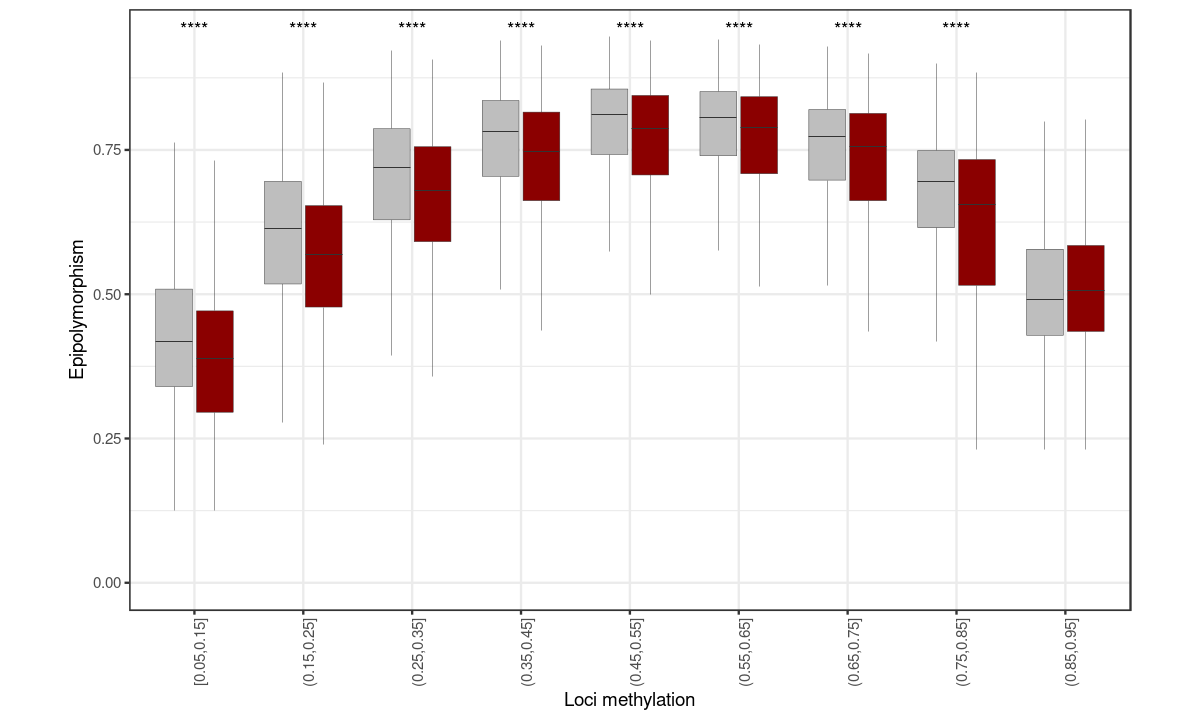

In [72]:
options(repr.plot.width = 10, repr.plot.height = 6)
p_gen_epipoly <- gen_epi %>%
        mutate(pat_meth = cut(pat_meth, seq(0.05, 1, 0.1), include.lowest = TRUE)) %>%
        filter(!is.na(pat_meth)) %>% 
        filter(!is.na(epipoly), !is.na(type)) %>% 
        ggplot(aes(x = pat_meth, y = epipoly, fill = type)) +
        geom_boxplot(outlier.shape = NA, outlier.size = 0.05, lwd =0.1) +
        scale_fill_manual(values = c(bg = "gray", reg = "darkred"), guide = FALSE) +
        vertical_labs() +
        xlab("Loci methylation") +
        ylab("Epipolymorphism") +
        ggpubr::stat_compare_means(label = "p.signif", hide.ns = TRUE, method = "wilcox.test", method.args = list(alternative = "less")) +
        theme(aspect.ratio = 0.6)

p_gen_epipoly + theme_bw() + vertical_labs() + theme(aspect.ratio = 0.6)

## Examples for cis regulation (non-promoters)

In [73]:
genes <- c("DNMT3A", "GATA3", "TBX1", "FGFR4", "PAX8")
min_dist <- 1e5
min_tss_dist <- 2e3
top_cands <- genomic_cis_cands %>% filter(gene %in% genes, type == "obs", rank == 1,  !is.na(dist),abs(dist) <= min_dist, abs(dist) >= min_tss_dist) %>% arrange(gene, cor) %>% group_by(gene) %>% slice(1) %>% ungroup()

In [74]:
top_cands

chrom,start,end,type,rank,gene,cor,chrom_expr,start_expr,end_expr,strand_expr,dist,n_obs,n_shuff,fdr,ER
<chr>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>
chr2,25500066,25500185,obs,1,DNMT3A,-0.4868497,chr2,25475184,25475185,-1,-24881,2680,92,0.03432836,ER+
chr5,176536239,176536567,obs,1,FGFR4,-0.5220844,chr5,176513872,176513873,1,22366,1331,107,0.08039068,ER-
chr10,8110463,8110569,obs,1,GATA3,-0.5098628,chr10,8096666,8096667,1,13796,1331,107,0.08039068,ER-
chr2,113993163,113993302,obs,1,PAX8,-0.6831847,chr2,114036498,114036499,-1,43196,2680,92,0.03432836,ER+
chr22,19749606,19749740,obs,1,TBX1,-0.5967496,chr22,19744225,19744226,1,5380,2680,92,0.03432836,ER+


In [75]:
meth_df <- get_cis_genomic_examples_cg_meth(genes = genes, scope = 2e4, min_dist = min_dist, min_tss_dist = min_tss_dist) %>% distinct(chrom, start, end, samp, cov, meth, ER)

In [76]:
expr_mat <- get_gene_expression_mat() %>% filter(name %in% genes) %>% select(-(chrom:end), -name3.chr) %>% column_to_rownames('name') %>% as.matrix()

In [77]:
expr_df <- expr_mat %>% gather_matrix(x = "samp", y = "gene", val = "expr")

In [78]:
top_cands

chrom,start,end,type,rank,gene,cor,chrom_expr,start_expr,end_expr,strand_expr,dist,n_obs,n_shuff,fdr,ER
<chr>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>
chr2,25500066,25500185,obs,1,DNMT3A,-0.4868497,chr2,25475184,25475185,-1,-24881,2680,92,0.03432836,ER+
chr5,176536239,176536567,obs,1,FGFR4,-0.5220844,chr5,176513872,176513873,1,22366,1331,107,0.08039068,ER-
chr10,8110463,8110569,obs,1,GATA3,-0.5098628,chr10,8096666,8096667,1,13796,1331,107,0.08039068,ER-
chr2,113993163,113993302,obs,1,PAX8,-0.6831847,chr2,114036498,114036499,-1,43196,2680,92,0.03432836,ER+
chr22,19749606,19749740,obs,1,TBX1,-0.5967496,chr22,19744225,19744226,1,5380,2680,92,0.03432836,ER+


#### Figure 3H

[1] "DNMT3A" "FGFR4"  "GATA3"  "PAX8"   "TBX1"  
[1] "ER+" "ER-" "ER-" "ER+" "ER+"
[1] "DNMT3A"


Joining, by = "samp"

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


[1] "FGFR4"


Joining, by = "samp"

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


[1] "GATA3"


Joining, by = "samp"

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


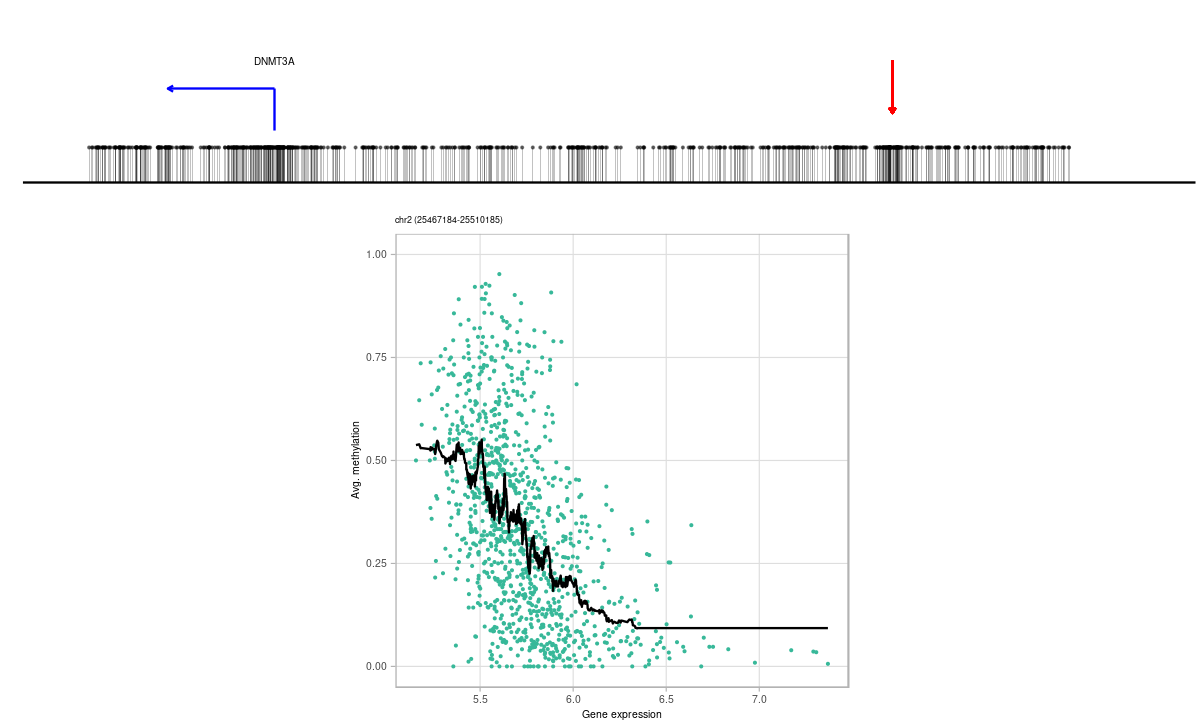

[1] "PAX8"


Joining, by = "samp"



Error : Problem with `mutate()` column `cor`.
ℹ `cor = cor(meth, expr, use = "pairwise.complete.obs", method = "spearman")`.
✖ both 'x' and 'y' must be non-empty
NULL
[1] "TBX1"


Joining, by = "samp"

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


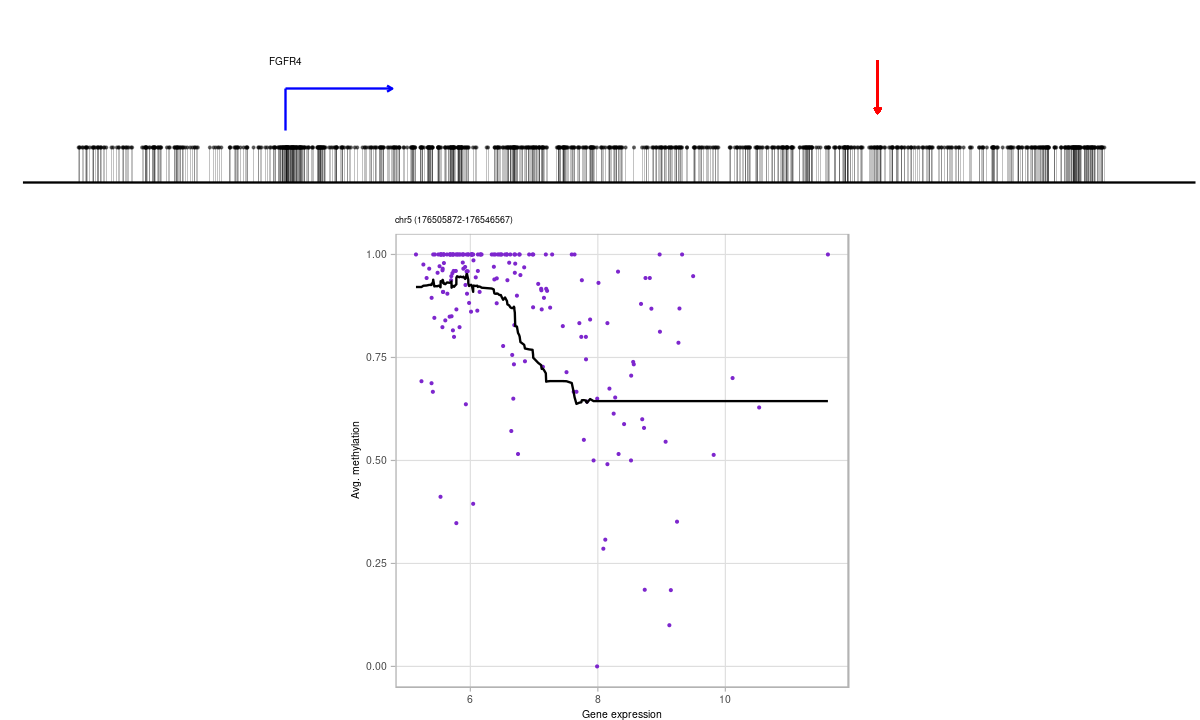

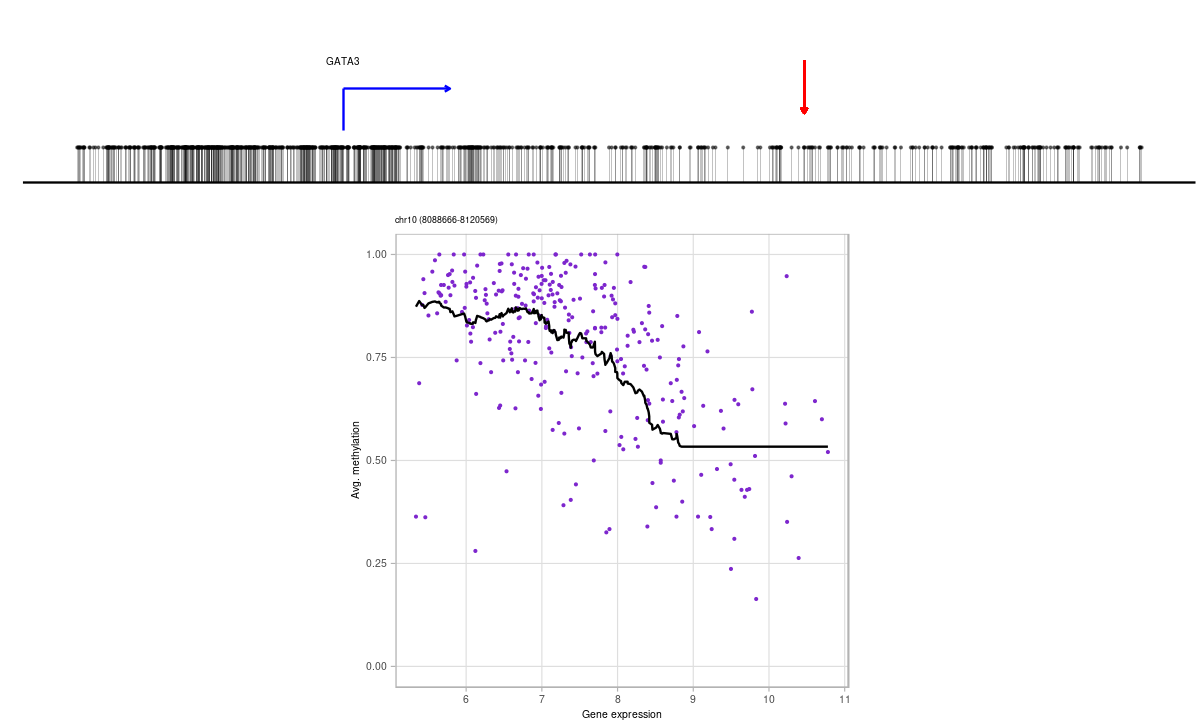

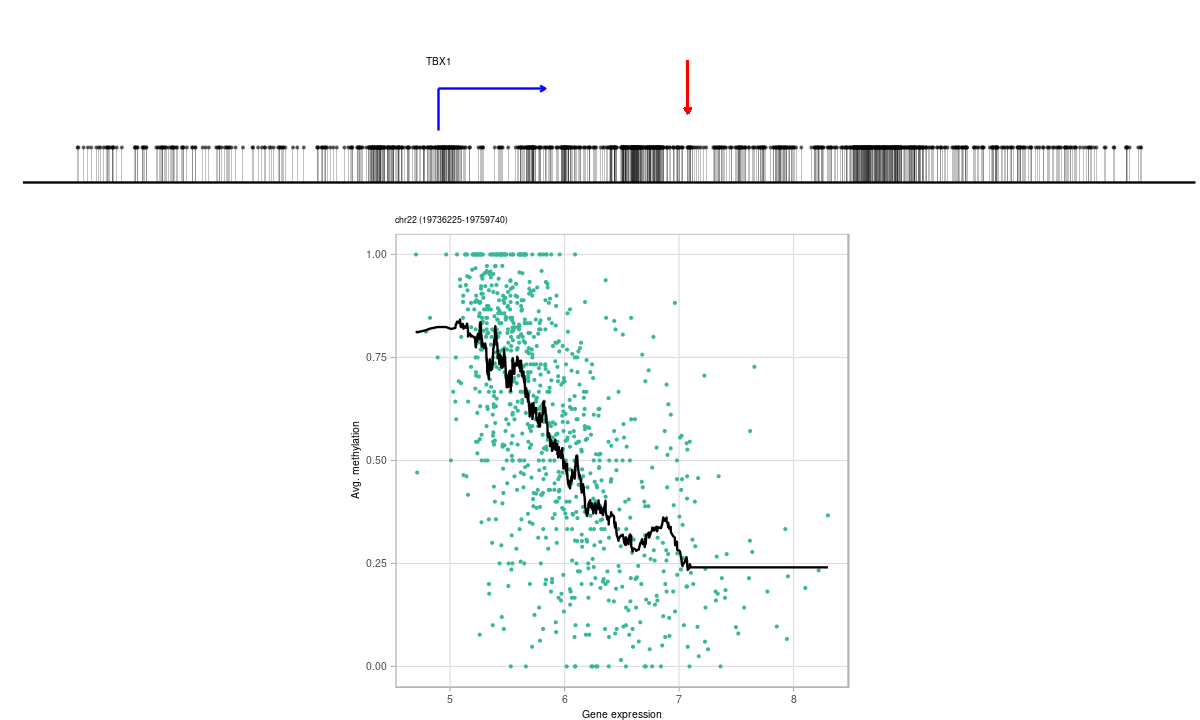

In [79]:
genes <- top_cands$gene
ERs <- top_cands$ER
print(genes)
print(ERs)
cis_examples <- list()
for (i in 1:length(genes)){
    print(genes[i])
    try(cis_examples[[genes[i]]] <- plot_cis_genomic_example(df = top_cands, gene = genes[i], expr_df = expr_df, meth_df = meth_df, ofn=NULL, k_smooth = 40, ER = ERs[i], scope_start = 8e3, scope_end = 1e4, add_pval = FALSE)    )
    print(cis_examples[[genes[i]]] )
}

In [ ]:
gc()